In [1]:
from keras.applications import VGG16

# VGG16 was designed to work on 224 x 224 pixel input images sizes
img_rows,img_cols = 224,224 

# Re-loads the VGG16 model without the top or FC layers
model = VGG16(weights = 'imagenet', 
                 include_top = False, 
                 input_shape = (img_rows, img_cols, 3))

# Here we freeze the last 4 layers 
# Layers are set to trainable as True by default
for layer in model.layers:
    layer.trainable = False
    
# Let's print our layers 
for (i,layer) in enumerate(model.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [5]:
def RG(bottom_model, num_classes):
    """creates the top or head of the model that will be 
    placed ontop of the bottom layers"""

    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


In [ ]:
model.input

<tf.Tensor 'input_2:0' shape=(None, 224, 224, 3) dtype=float32>

In [3]:
model.layers

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

# Set our class number to 3 (Young, Middle, Old)
num_classes = 2

FC_Head = RG(model, num_classes)

model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
from zipfile import ZipFile
file_name = "Faces.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print("done")

done


In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_data_dir = '/content/Faces/Train/'
validation_data_dir = '/content/Faces/Validation/'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.2,
      height_shift_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
batchsize = 32
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=32,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batchsize,
        class_mode='categorical')

Found 220 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [39]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
                   
checkpoint = ModelCheckpoint("ravi_vgg.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

# Note we use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 160
nb_validation_samples = 60
epochs = 5
batch_size = 4
history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/5
40/40 [==============================] - 25s 632ms/step - loss: 0.5421 - accuracy: 0.9467 - val_loss: 0.5539 - val_accuracy: 0.8827

Epoch 00001: val_loss improved from inf to 0.55389, saving model to ravi_vgg.h5
Epoch 2/5
40/40 [==============================] - 24s 607ms/step - loss: 0.1876 - accuracy: 0.9333 - val_loss: 0.2007 - val_accuracy: 0.8839

Epoch 00002: val_loss improved from 0.55389 to 0.20074, saving model to ravi_vgg.h5
Epoch 3/5
40/40 [==============================] - 24s 599ms/step - loss: 0.1493 - accuracy: 0.9538 - val_loss: 0.2534 - val_accuracy: 0.9004

Epoch 00003: val_loss did not improve from 0.20074
Epoch 4/5
40/40 [==============================] - 23s 584ms/step - loss: 0.1609 - accuracy: 0.9506 - val_loss: 0.6548 - val_accuracy: 0.8683

Epoch 00004: val_loss did not improve from 0.20074
Epoch 5/5
40/40 [==============================] - 25s 616ms/step - loss: 0.1720 - accuracy: 0.9452 - val_loss: 0.1790 - val_accuracy: 0.8673

Epoch 00005: val_lo

In [60]:
from keras.models import load_model

classifier = load_model('ravi_vgg.h5')

Class - Narendra Modi


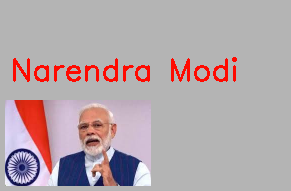

Class - Amit Shah


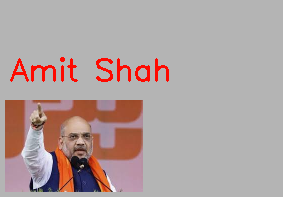

Class - Amit Shah


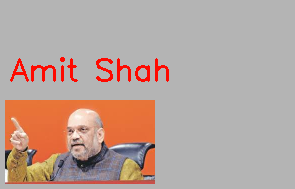

Class - Narendra Modi


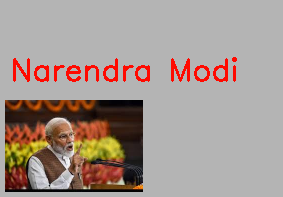

Class - Amit Shah


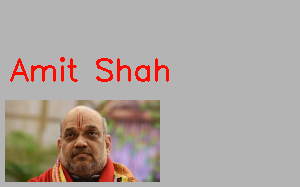

Class - Narendra Modi


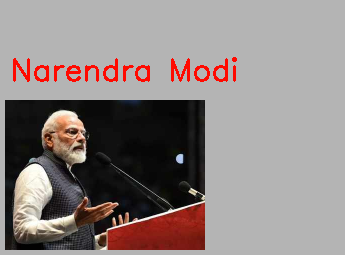

Class - Amit Shah


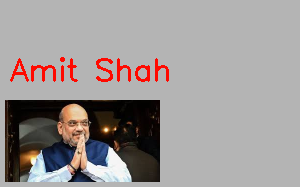

Class - Amit Shah


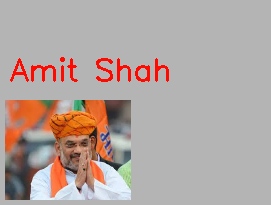

Class - Amit Shah


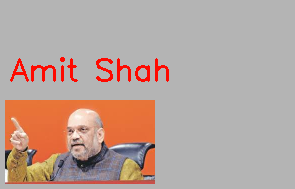

Class - Narendra Modi


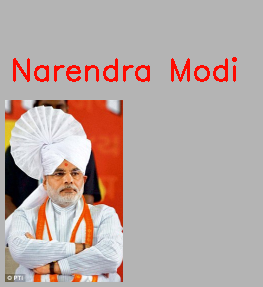

In [62]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import os
from os import listdir
from os.path import isfile, join

my_dict = {"[0]":"Amit Shah", 
           "[1]": "Narendra Modi "}

my_dict_n = {"HM": "Amit Shah",
            "PM": "Narendra Modi"}

def draw_test(name, pred, im):
    home = my_dict[str(pred)]
    GREY = [180,180,180]
    expanded_image = cv2.copyMakeBorder(im, 100, 5, 5, 140 ,cv2.BORDER_CONSTANT,value=GREY)
    cv2.putText(expanded_image, home, (10, 80) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,10,255), 2)
    cv2_imshow( expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + my_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/content/Faces/Validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(model.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()